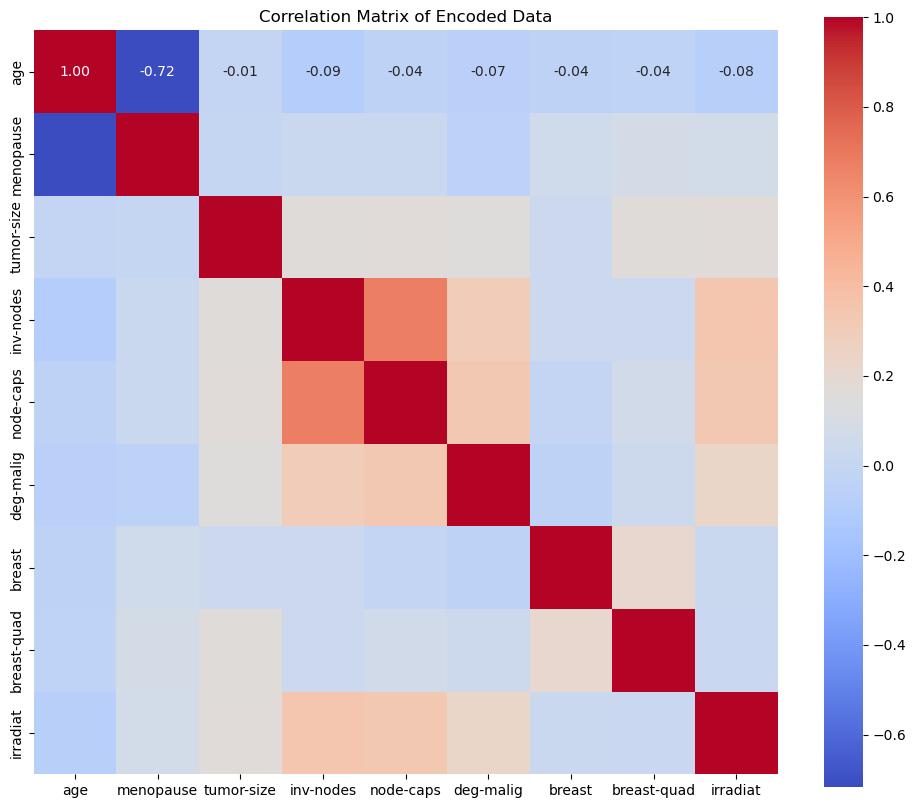

c:\Users\Julien Delaunay\.conda\envs\globalEHR\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


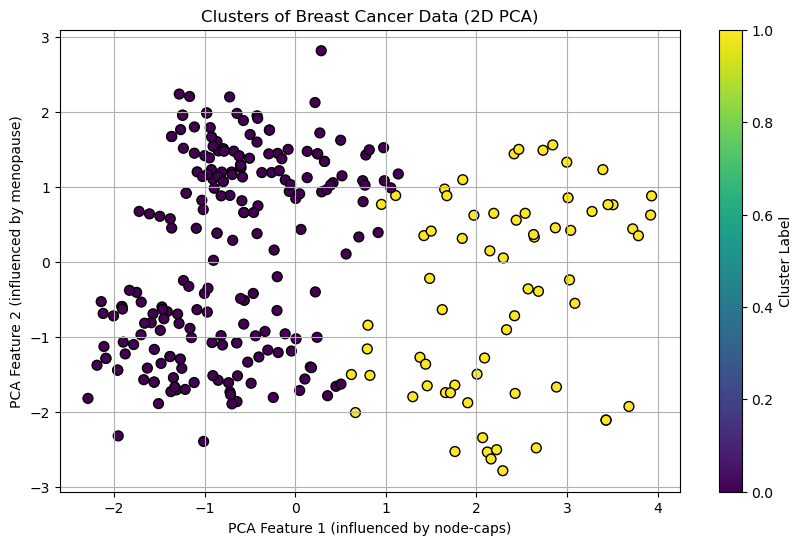

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
# Load the data
data_path = 'breast_cancer.csv'  # Update the path if needed
data = pd.read_csv(data_path)
data.dropna(inplace=True)

x_data = data.loc[:, data.columns != "Class"]
y_data = data.loc[:, data.columns == "Class"]

# Encode categorical variables
le = LabelEncoder()
encoded_data = x_data.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)

# Perform Standard Scaling on encoded data for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(encoded_data)

# Plotting the correlation matrix of the original encoded data
corr_matrix = pd.DataFrame(scaled_data, columns=encoded_data.columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Encoded Data')
plt.show()
# Perform K-means clustering
n_clusters = 2  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
kmeans = kmeans.fit(scaled_data)
cluster_labels = kmeans.predict(scaled_data)


# Perform PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
components = pca.components_

# Identify the most significant features for each principal component
feature_indices = np.argsort(np.abs(components), axis=1)[:, -1]
most_significant_features = [data.columns[indices] for indices in feature_indices]

# Plotting the clusters with named PCA features
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters of Breast Cancer Data (2D PCA)')
plt.xlabel(f'PCA Feature 1 (influenced by {most_significant_features[0]})')
plt.ylabel(f'PCA Feature 2 (influenced by {most_significant_features[1]})')
plt.grid(True)
plt.colorbar(label='Cluster Label')
plt.show()




In [2]:
print("most important features", most_significant_features)
print("k means centers", kmeans.cluster_centers_)
print("label", kmeans.predict(kmeans.cluster_centers_))
print(encoded_data.columns)

most important features ['node-caps', 'menopause']
k means centers [[ 0.0427601  -0.00343305 -0.10819327 -0.47292161 -0.47966847 -0.21650649
  -0.01022271 -0.02725765 -0.25138499]
 [-0.13402418  0.01076029  0.33911323  1.48229163  1.50343849  0.67860244
   0.03204134  0.08543443  0.7879231 ]]
label [0 1]
Index(['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat'],
      dtype='object')


In [3]:
# Initialize an anchor explainer technique that use decision rules to explain specific decision taken by a classifier
from anchor import utils
from anchor import anchor_tabular
class_names = ["no-recurrence-events", "recurrence-events"] 
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names,
    encoded_data.columns,
    scaled_data)

In [4]:
# Use the anchor to explain the prediction of the cluster center of the first cluster
np.random.seed(1)
idx = 0
print('Prediction: ', explainer.class_names[kmeans.predict(kmeans.cluster_centers_[idx].reshape(1, -1))[0]])
exp = explainer.explain_instance(kmeans.cluster_centers_[idx], kmeans.predict, threshold=0.95)

Prediction:  no-recurrence-events


In [5]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: -1.11 < menopause <= 0.92 AND deg-malig <= -0.08 AND tumor-size <= -0.03 AND breast-quad > -0.72 AND breast <= 1.05
Precision: 0.92
Coverage: 0.13


In [6]:
# Use the anchor to explain the prediction of the cluster center of the second cluster
idx = 1
print('Prediction: ', explainer.class_names[kmeans.predict(kmeans.cluster_centers_[idx].reshape(1, -1))[0]])
exp = explainer.explain_instance(kmeans.cluster_centers_[idx], kmeans.predict, threshold=0.95)

Prediction:  recurrence-events


In [7]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: node-caps > -0.50 AND inv-nodes > -0.54
Precision: 1.00
Coverage: 0.18


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

train_scaled_data, test_scaled_data, y_train, y_test = train_test_split(scaled_data, y_data, test_size=0.33, random_state=42)
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf = clf.fit(train_scaled_data, y_train)
print(clf.predict(test_scaled_data)[:10])

['no-recurrence-events' 'no-recurrence-events' 'no-recurrence-events'
 'no-recurrence-events' 'no-recurrence-events' 'no-recurrence-events'
 'no-recurrence-events' 'no-recurrence-events' 'no-recurrence-events'
 'no-recurrence-events']


c:\Users\Julien Delaunay\.conda\envs\globalEHR\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [9]:
# Use the anchor to explain the prediction of a random forest classifier on an instance of the test set
model = clf
np.random.seed(1)
idx = 0
print('Prediction: ', model.predict(test_scaled_data[idx].reshape(1, -1))[0])
exp = explainer.explain_instance(test_scaled_data[idx], clf.predict, threshold=0.95)

Prediction:  no-recurrence-events


In [10]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: inv-nodes <= -0.54 AND node-caps <= -0.50
Precision: 1.00
Coverage: 0.72


c:\Users\Julien Delaunay\.conda\envs\globalEHR\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0 0 0 0 0 0 0 0 0 0]


c:\Users\Julien Delaunay\.conda\envs\globalEHR\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


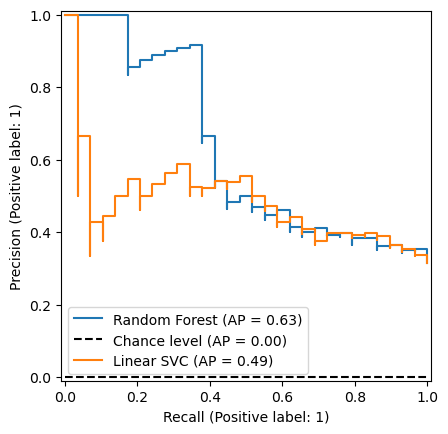

In [11]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

# Convert the column of target labels into a list of 0 and 1
y_data_int = binary_labels = y_data.map(lambda x: 1 if x == 'recurrence-events' else 0)
train_data, test_data, y_train, y_test = train_test_split(x_data, y_data_int, test_size=0.33, random_state=42)

# Fit a Random Forest classifier on the training dataset
encoder = OneHotEncoder()
encoder.fit(x_data.values)
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
clf.fit(encoder.transform(train_data.values), y_train)

predict_fn = lambda x: clf.predict(encoder.transform(x))
y_pred = predict_fn(test_data.values)
print(y_pred[:10])

fig, ax = plt.subplots()
# Measure precision recall of the Random Forest classifier
display = PrecisionRecallDisplay.from_estimator(
    clf, encoder.transform(test_data.values), y_test, name="Random Forest", plot_chance_level=True, ax=ax
)

# Compare precision recall of the Random Forest with a simple Linear Support Vector Classifier
classifier = LinearSVC(random_state=42, dual="auto")
classifier.fit(encoder.transform(train_data.values), y_train)

display = PrecisionRecallDisplay.from_estimator(
    classifier, encoder.transform(test_data.values), y_test, name="Linear SVC", ax=ax#, plot_chance_level=True
)


In [12]:
from sklearn.metrics import accuracy_score

encoder = OneHotEncoder()
encoder.fit(x_data.values)
# Use the anchor to explain the prediction of a random forest classifier on an instance of the test set
c = RandomForestClassifier(n_estimators=50, n_jobs=5)
c.fit(encoder.transform(train_data.values), y_train)
predict_fn = lambda x: c.predict(encoder.transform(x).toarray())

print('Train', accuracy_score(y_train, predict_fn(train_data.values)))
print('Test', accuracy_score(y_test, predict_fn(test_data.values)))

c:\Users\Julien Delaunay\.conda\envs\globalEHR\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train 0.9783783783783784
Test 0.7065217391304348


In [13]:
print(predict_fn(test_data.to_numpy()[idx].reshape(1, -1)))
print('Prediction: ', explainer.class_names[predict_fn(test_data.to_numpy()[idx].reshape(1, -1))[0]])

categorical_features = list(range(0, x_data.shape[1]))
categorical_names = {}
temp_data = test_data.to_numpy()
for feature in categorical_features:
        le = LabelEncoder()
        le.fit(temp_data[:, feature])
        temp_data[:, feature] = le.transform(temp_data[:, feature])
        categorical_names[feature] = le.classes_

explainer = anchor_tabular.AnchorTabularExplainer(
    class_names,
    encoded_data.columns,
    train_data.to_numpy(),
    categorical_names
    )


[0]
Prediction:  no-recurrence-events


In [14]:
from anchor import anchor_tabular
print(test_data.to_numpy()[idx])
print(predict_fn(test_data.to_numpy()[idx].reshape(1, -1)))

explication = explainer.explain_instance(test_data.to_numpy()[idx], predict_fn, threshold=0.95)

['50-59' 'ge40' '25-29' '0-2' 'no' 3 'left' 'right_up' 'no']
[0]


In [15]:
print('Anchor: %s' % (' AND '.join(explication.names())))
print('Precision: %.2f' % explication.precision())
print('Coverage: %.2f' % explication.coverage())

Anchor: menopause = ge40 AND inv-nodes = 0-2 AND breast = left AND irradiat = no
Precision: 0.97
Coverage: 0.16


In [16]:
exps = []
for index in range(20):
    print("index", index)
    print(test_data.to_numpy()[index])
    exps.append(explainer.explain_instance(test_data.to_numpy()[index], predict_fn, threshold=0.95))

index 0
['50-59' 'ge40' '25-29' '0-2' 'no' 3 'left' 'right_up' 'no']
index 1
['40-49' 'premeno' '30-34' '0-2' 'no' 3 'right' 'right_up' 'no']
index 2
['40-49' 'ge40' '30-34' '0-2' 'no' 2 'left' 'left_up' 'yes']
index 3
['40-49' 'premeno' '40-44' '0-2' 'no' 2 'right' 'left_low' 'no']
index 4
['40-49' 'premeno' '20-24' '3-5' 'yes' 2 'right' 'right_up' 'yes']
index 5
['40-49' 'premeno' '30-34' '0-2' 'no' 1 'left' 'left_low' 'no']
index 6
['60-69' 'ge40' '20-24' '0-2' 'no' 2 'left' 'left_up' 'no']
index 7
['40-49' 'premeno' '20-24' '3-5' 'no' 2 'right' 'left_low' 'no']
index 8
['50-59' 'ge40' '0-4' '0-2' 'no' 2 'left' 'central' 'no']
index 9
['50-59' 'ge40' '15-19' '0-2' 'no' 2 'right' 'right_up' 'no']
index 10
['30-39' 'premeno' '0-4' '0-2' 'no' 2 'right' 'central' 'no']
index 11
['70-79' 'ge40' '40-44' '0-2' 'no' 1 'right' 'left_up' 'no']
index 12
['40-49' 'premeno' '30-34' '12-14' 'yes' 3 'left' 'left_up' 'yes']
index 13
['50-59' 'premeno' '25-29' '0-2' 'no' 2 'left' 'right_up' 'no']
in

In [17]:
for i in range(len(exps)):
    print()
    print("instance", i)
    print(test_data.to_numpy()[i])
    print('Prediction: ', explainer.class_names[predict_fn(test_data.to_numpy()[i].reshape(1, -1))[0]])
    print('Anchor: %s' % (' AND '.join(exps[i].names())))
    print('Precision: %.2f' % exps[i].precision())
    print('Coverage: %.2f' % exps[i].coverage())


instance 0
['50-59' 'ge40' '25-29' '0-2' 'no' 3 'left' 'right_up' 'no']
Prediction:  no-recurrence-events
Anchor: menopause = ge40 AND inv-nodes = 0-2 AND breast = left
Precision: 0.95
Coverage: 0.18

instance 1
['40-49' 'premeno' '30-34' '0-2' 'no' 3 'right' 'right_up' 'no']
Prediction:  no-recurrence-events
Anchor: breast = right AND inv-nodes = 0-2 AND irradiat = no AND breast-quad = right_up
Precision: 1.00
Coverage: 0.03

instance 2
['40-49' 'ge40' '30-34' '0-2' 'no' 2 'left' 'left_up' 'yes']
Prediction:  no-recurrence-events
Anchor: menopause = ge40 AND inv-nodes = 0-2 AND age = 40-49
Precision: 0.96
Coverage: 0.01

instance 3
['40-49' 'premeno' '40-44' '0-2' 'no' 2 'right' 'left_low' 'no']
Prediction:  no-recurrence-events
Anchor: tumor-size = 40-44 AND node-caps = no AND deg-malig = 3
Precision: 0.97
Coverage: 0.02

instance 4
['40-49' 'premeno' '20-24' '3-5' 'yes' 2 'right' 'right_up' 'yes']
Prediction:  recurrence-events
Anchor: node-caps = yes AND irradiat = yes AND breast-

In [18]:
n_clusters = 2  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
kmeans = kmeans.fit(encoder.transform(train_data.values))#, y_train)
predict_kmeans_fn = lambda x: kmeans.predict(encoder.transform(x).toarray())

print('Train', accuracy_score(y_train, predict_kmeans_fn(train_data.values)))
print('Test', accuracy_score(y_test, predict_kmeans_fn(test_data.values)))

exp_kmeans0 = explainer.explain_instance(encoder.inverse_transform(kmeans.cluster_centers_[0].reshape(1, -1)), predict_kmeans_fn, threshold=0.95)
exp_kmeans1 = explainer.explain_instance(encoder.inverse_transform(kmeans.cluster_centers_[1].reshape(1, -1)), predict_kmeans_fn, threshold=0.95)
for i, exp_kmeans in enumerate([exp_kmeans0, exp_kmeans1]):
    print(encoder.inverse_transform(kmeans.cluster_centers_[i].reshape(1, -1)))
    print('Prediction: ', explainer.class_names[predict_kmeans_fn(encoder.inverse_transform(kmeans.cluster_centers_[i].reshape(1, -1)))[0]])
    print('Anchor: %s' % (' AND '.join(exp_kmeans.names())))
    print('Precision: %.2f' % exp_kmeans.precision())
    print('Coverage: %.2f' % exp_kmeans.coverage())

Train 0.518918918918919
Test 0.4891304347826087
[['40-49' 'premeno' '25-29' '0-2' 'no' 2 'right' 'left_up' 'no']]
Prediction:  no-recurrence-events
Anchor: breast = right
Precision: 1.00
Coverage: 0.46
[['50-59' 'premeno' '30-34' '0-2' 'no' 2 'left' 'left_low' 'no']]
Prediction:  recurrence-events
Anchor: breast = left
Precision: 1.00
Coverage: 0.55


In [19]:
# Individu 1
individu_1 = np.asarray(['50-59', 'premeno', '30-34', '3-5', 'yes', 3, 'right', 'left_up', 'yes'], dtype="O").reshape(1, -1)
print(individu_1)
explication_chatgpt = explainer.explain_instance(individu_1, predict_fn, threshold=0.95)
print('Anchor: %s' % (' AND '.join(explication_chatgpt.names())))
print('Prediction: ', explainer.class_names[predict_fn(individu_1)[0]])
print()

# Individu 2
individu_2 = np.asarray(['40-49', 'lt40', '15-19', '0-2', 'no', 1, 'left', 'right_low', 'no'], dtype="O").reshape(1, -1)
print(individu_2)
explication_chatgpt = explainer.explain_instance(individu_2, predict_fn, threshold=0.95)
print('Anchor: %s' % (' AND '.join(explication_chatgpt.names())))
print('Prediction: ', explainer.class_names[predict_fn(individu_2)[0]])

[['50-59' 'premeno' '30-34' '3-5' 'yes' 3 'right' 'left_up' 'yes']]
Anchor: inv-nodes = 3-5 AND tumor-size = 30-34 AND breast-quad = left_up AND menopause = premeno AND node-caps = yes
Prediction:  recurrence-events

[['40-49' 'lt40' '15-19' '0-2' 'no' 1 'left' 'right_low' 'no']]
Anchor: breast-quad = right_low AND inv-nodes = 0-2 AND irradiat = no
Prediction:  no-recurrence-events
